## Applied AI Assesment
## Face Mask Detection using Deep learning

In [1]:
# data set Source below
# https://www.kaggle.com/datasets/omkargurav/face-mask-dataset

### Import neccesary Libraries

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.optimizers import SGD
from keras import regularizers
import tensorflow as tf
import numpy as np
import cv2
import os
from PIL import Image
from sklearn.model_selection import train_test_split

2023-08-25 13:40:32.657387: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# pip install opencv-python
# !pip install Pillow

In [4]:

trainpath = "./data/"

In [5]:
# retrieved from https://www.tutorialspoint.com/python/os_listdir.htm
# listing out images from their directories
with_mask = os.listdir(f"{trainpath}WithMask/")
without_mask = os.listdir(f"{trainpath}WithoutMask/")

In [6]:
with_mask_len = len(with_mask)
without_mask_len = len(without_mask)

In [7]:
print(f"total images with mask {with_mask_len} \
Total Image Without file {without_mask_len}")

total images with mask 3725 Total Image Without file 3828


In [8]:
without_mask[:2]

['without_mask_3593.jpg', 'without_mask_2855.jpg']

In [9]:
with_mask[:5]

['with_mask_2140.jpg',
 'with_mask_1449.jpg',
 'with_mask_2626.jpg',
 'with_mask_942.jpg',
 'with_mask_3538.jpg']

#### Plot of Image With and without mask

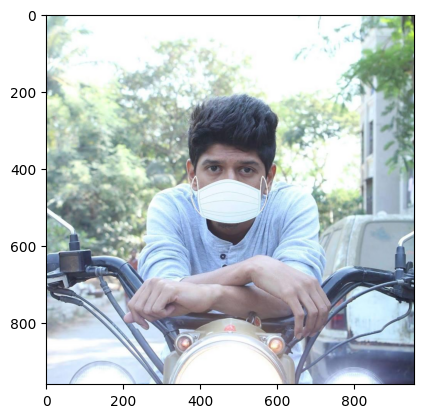

In [10]:
# retrieved from  https://stackoverflow.com/questions/35286540/display-an-image-with-python
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(f"{trainpath}WithMask/with_mask_942.jpg")
imgplot = plt.imshow(img)
plt.show()

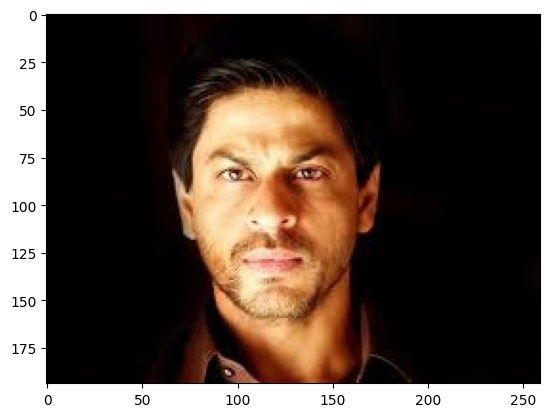

In [11]:
# retrieved from  https://stackoverflow.com/questions/35286540/display-an-image-with-python
img = mpimg.imread(f"{trainpath}WithoutMask/without_mask_3593.jpg")
imgplot = plt.imshow(img)
plt.show()
# 348.png

### Image preprocessing

I defined the function below for preprocessing task. it will help in reshaping the image, anc converting all images to RGB format. the function accepts image directry, and folder type by i kept WithMask as default folder type. Then it returns the processed image

In [12]:
# inspired by https://cloudinary.com/guides/bulk-image-resize/python-image-resize-with-pillow-and-opencv
# reshape Images so that they can maintain thesame shape

def resizeImage(imageDir,folderType ="WithMask" ):
    processed_images =[]
    for img in imageDir: # loop through masked images
        image = Image.open(f"{trainpath}{folderType}/{img}") # read Image
        new_image = image.resize((128, 128)) #reshape image to 120
        new_image = new_image.convert("RGB")
        processed_images.append(np.array(new_image)) #store the image to np_images list
    return processed_images

In [13]:
# Call the defined function for Image preprocessing
withMaskImages = resizeImage(with_mask)
withoutMaskImages = resizeImage(without_mask,"WithoutMask")

/usr/local/Cellar/jupyterlab/3.4.8_1/libexec/lib/python3.11/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [14]:
# concatenate masked and unmasked images together
combinedImages = withMaskImages + withoutMaskImages

In [15]:
combinedImages[0]

array([[[226, 213, 197],
        [226, 213, 197],
        [226, 213, 197],
        ...,
        [214, 201, 182],
        [214, 201, 182],
        [214, 201, 182]],

       [[226, 213, 197],
        [226, 213, 197],
        [226, 213, 197],
        ...,
        [214, 201, 182],
        [214, 201, 182],
        [214, 201, 182]],

       [[226, 213, 197],
        [226, 213, 197],
        [226, 213, 197],
        ...,
        [214, 201, 182],
        [214, 201, 182],
        [214, 201, 182]],

       ...,

       [[235, 225, 216],
        [235, 225, 216],
        [235, 225, 216],
        ...,
        [219, 206, 189],
        [219, 206, 189],
        [219, 206, 189]],

       [[235, 225, 216],
        [235, 225, 216],
        [235, 225, 216],
        ...,
        [219, 206, 189],
        [219, 206, 189],
        [219, 206, 189]],

       [[235, 225, 216],
        [235, 225, 216],
        [235, 225, 216],
        ...,
        [217, 204, 187],
        [217, 204, 187],
        [217, 204, 187]]

### Label Creation for faces with mask and without mask

For this, I will represent image with mask as 1 and without mask as 0

In [16]:
# create label for with and without mask
withmask_label = [1 for i in range(with_mask_len)]
withoutmask_label = [0 for i in range(without_mask_len)]

In [17]:
# concat both label for masked and unmasked together
combined_label = withmask_label + withoutmask_label

In [18]:
combinedImages[0]

array([[[226, 213, 197],
        [226, 213, 197],
        [226, 213, 197],
        ...,
        [214, 201, 182],
        [214, 201, 182],
        [214, 201, 182]],

       [[226, 213, 197],
        [226, 213, 197],
        [226, 213, 197],
        ...,
        [214, 201, 182],
        [214, 201, 182],
        [214, 201, 182]],

       [[226, 213, 197],
        [226, 213, 197],
        [226, 213, 197],
        ...,
        [214, 201, 182],
        [214, 201, 182],
        [214, 201, 182]],

       ...,

       [[235, 225, 216],
        [235, 225, 216],
        [235, 225, 216],
        ...,
        [219, 206, 189],
        [219, 206, 189],
        [219, 206, 189]],

       [[235, 225, 216],
        [235, 225, 216],
        [235, 225, 216],
        ...,
        [219, 206, 189],
        [219, 206, 189],
        [219, 206, 189]],

       [[235, 225, 216],
        [235, 225, 216],
        [235, 225, 216],
        ...,
        [217, 204, 187],
        [217, 204, 187],
        [217, 204, 187]]

### Set X and y Variables

In [19]:
# convert all the images to numpy array and assign to X 
X = np.array(combinedImages)
# convert all the labels to numpy array and assign to Y 
y = np.array(combined_label)

In [20]:
X[0]

array([[[226, 213, 197],
        [226, 213, 197],
        [226, 213, 197],
        ...,
        [214, 201, 182],
        [214, 201, 182],
        [214, 201, 182]],

       [[226, 213, 197],
        [226, 213, 197],
        [226, 213, 197],
        ...,
        [214, 201, 182],
        [214, 201, 182],
        [214, 201, 182]],

       [[226, 213, 197],
        [226, 213, 197],
        [226, 213, 197],
        ...,
        [214, 201, 182],
        [214, 201, 182],
        [214, 201, 182]],

       ...,

       [[235, 225, 216],
        [235, 225, 216],
        [235, 225, 216],
        ...,
        [219, 206, 189],
        [219, 206, 189],
        [219, 206, 189]],

       [[235, 225, 216],
        [235, 225, 216],
        [235, 225, 216],
        ...,
        [219, 206, 189],
        [219, 206, 189],
        [219, 206, 189]],

       [[235, 225, 216],
        [235, 225, 216],
        [235, 225, 216],
        ...,
        [217, 204, 187],
        [217, 204, 187],
        [217, 204, 187]]

In [21]:
len(X)

7553

In [22]:
type(y)

numpy.ndarray

In [23]:
len(y)

7553

In [24]:
print(X.shape)

(7553, 128, 128, 3)


### Split Data into train and test

In [25]:
# use 20% for test 80% for trainning
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [26]:
# 80% of the data
X_train.shape

(6042, 128, 128, 3)

In [27]:
# 20% of the data
X_test.shape

(1511, 128, 128, 3)

In [28]:
# http://carina.cse.lehigh.edu/Data_Analytics_Course/1.%20Image%20Classification%20using%20Neural%20Network.html
# normalize inputs from 0-255 to 0-1
X_train = X_train/ 255
X_test = X_test/ 255

In [29]:
X_train[0]

array([[[0.5372549 , 0.63529412, 0.63529412],
        [0.50196078, 0.58823529, 0.58039216],
        [0.38039216, 0.4627451 , 0.45490196],
        ...,
        [0.25490196, 0.25882353, 0.23529412],
        [0.26666667, 0.27058824, 0.24705882],
        [0.27058824, 0.2745098 , 0.25098039]],

       [[0.50980392, 0.6       , 0.6       ],
        [0.41960784, 0.50588235, 0.49803922],
        [0.33333333, 0.41176471, 0.40392157],
        ...,
        [0.21568627, 0.21960784, 0.19607843],
        [0.23137255, 0.23529412, 0.21176471],
        [0.25098039, 0.25490196, 0.23137255]],

       [[0.44313725, 0.5254902 , 0.51764706],
        [0.32156863, 0.40392157, 0.4       ],
        [0.27843137, 0.35294118, 0.34509804],
        ...,
        [0.21176471, 0.21568627, 0.19215686],
        [0.22352941, 0.22745098, 0.20784314],
        [0.23921569, 0.24313725, 0.22352941]],

       ...,

       [[0.87843137, 0.95294118, 0.94509804],
        [0.88235294, 0.95686275, 0.94901961],
        [0.87843137, 0

### Helper function to help plot graph

In [30]:
# this function takes in history as argument and 
# plots the graph of the data passed
def plot_graph(history):
    # Plot training and validation accuracy
    #Plots the training accuracy as a line with label "Training Accuracy".
    plt.plot(history.history['acc'], label='Training Accuracy')
    #Plots the validation accuracy as a line with label "Validation Accuracy".
    plt.plot(history.history['val_acc'], label='Validation Accuracy')
    #Sets the title of the plot to "Training and Validation Accuracy".
    plt.title('Training and Validation Accuracy')
    #Sets the label of the x-axis to "Epochs".
    plt.xlabel('Epochs')
    #Sets the label of the y-axis to "Accuracy".
    plt.ylabel('Accuracy')
    #Shows the legend of the plot with the labels of the two lines.
    plt.legend()
    #Shows the plot on the screen.
    plt.show()
    
    
    ## checking for overfitting
    # Plot training loss against validation loss
    #Plots the training loss as a line with label "Training Loss".
    plt.plot(history.history['loss'], label='Training Loss')
    #Plots the validation loss as a line with label "Validation Loss".
    plt.plot(history.history['val_loss'], label='Validation Loss')
    #Sets the title of the plot to "Training and Validation Loss".
    plt.title('Training and Validation Loss')
    #Sets the label of the x-axis to "Epochs".
    plt.xlabel('Epochs')
    #Sets the label of the y-axis to "Loss".
    plt.ylabel('Loss')
    #Shows the legend of the plot with the labels of the two lines.
    plt.legend()
    #Shows the plot on the screen.
    plt.show()
    
    

### Building  Neural Network Model Architecture Using keras 

Firstly, I will be building a network architecture with 2 convolutional layers, 2 dropout function and adam optimizer

In [31]:
# referenced from my understanding AI lab work
model = Sequential()
# first convolutional layer
model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=(128,128,3),activation = 'relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2,2)))

# Second Convolutional layer
model.add(Conv2D(filters=64,kernel_size=(3,3),activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# flatten layer
model.add(Flatten())

# Dense layer
model.add(Dense(128,activation = 'relu'))
# in case of overfitting
model.add(Dropout(0.5))

# # Dense layer
model.add(Dense(64,activation = 'relu'))
# in case of overfitting
model.add(Dropout(0.5))

# number of the neuron has to be the number of class
# in my case, i have 2 classes (masked and unmasked)
# here also, i am using sigmoid because i am dealing with binary problem
model.add(Dense(2,activation = 'sigmoid'))

In [32]:
# print the summary of the model constructed
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 61504)             0         
                                                                 
 dense (Dense)               (None, 128)               7

In [33]:
# compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [34]:
len(X_train)

6042

In [35]:
len(X_test)

1511

In [36]:
# train the model with 8 epocs, use 20% for validation
history = model.fit(X_train, y_train, validation_split=0.1, epochs=8)

Epoch 1/8
 10/170 [>.............................] - ETA: 1:45 - loss: 1.0397 - acc: 0.5375

KeyboardInterrupt: 

In [ ]:
score = model.evaluate(X_test, y_test, verbose = 0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
# Plot graph of the training history summary
plot_graph(history)

##### From the above graph it was evident that the model had leanrt so well that at 5th epoch. The loss started growing up and accuracy started dropping. This could be due to small data set. Below, I am going to experiment with 3 convolutiona blocks and 5 epochs 

In [ ]:
# Architecture with 3 blocks

In [ ]:
# referenced from my understanding AI lab work
model2 = Sequential()
# first convolutional layer
model2.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=(128,128,3),activation = 'relu', padding="same"))
model2.add(MaxPooling2D(pool_size=(2,2)))

# Second Convolutional layer
model2.add(Conv2D(filters=64,kernel_size=(3,3),activation = 'relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

# # # Third layer
model2.add(Conv2D(filters=128,kernel_size=(3,3),activation = 'relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))


# flatten layer
model2.add(Flatten())

# Dense layer
model2.add(Dense(128,activation = 'relu'))
# in case of overfitting
model2.add(Dropout(0.5))

# # Dense layer
model2.add(Dense(64,activation = 'relu'))
# in case of overfitting
model2.add(Dropout(0.5))

# number of the neuron has to be the number of class
# in my case, i have 2 classes (masked and unmasked)
# here also, i am using sigmoid because i am dealing with binary problem
model2.add(Dense(2,activation = 'sigmoid'))

In [ ]:
# compile model with adam as optimizer 
model2.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
# train the model
history2 = model2.fit(X_train, y_train, validation_split=0.1, epochs=5)

##### Model Evaluation

In [ ]:
score2 = model2.evaluate(X_test, y_test, verbose = 0)

print('Test loss:', score2[0])
print('Test accuracy:', score2[1])

In [ ]:
# Plot graph of training history
plot_graph(history2)

#### we can see in the above that increasing the number of epochs and convolutional blocks improved the model and yielded Test accuracy of 95% and Test loss of 0.15

#### Below, I will be experimenting with 3 blocks, l2 regularization, learning rate of 0.0001 and drop out to see if I will have a better performance

In [ ]:
from keras.regularizers import l2  # Import L2 regularization


In [ ]:
# referenced from my understanding AI lab work
model3 = Sequential()
# first convolutional layer
model3.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=(128,128,3),activation = 'relu', padding="same"))
model3.add(MaxPooling2D(pool_size=(2,2)))

# Second Convolutional layer
model3.add(Conv2D(filters=64,kernel_size=(3,3),activation = 'relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))

# # # Third layer
model3.add(Conv2D(filters=128,kernel_size=(3,3),activation = 'relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))

# flatten layer
model3.add(Flatten())

# Dense layer
model3.add(Dense(128,activation = 'relu'))
# in case of overfitting
model3.add(Dropout(0.5))

# # Dense layer
model3.add(Dense(64,activation = 'relu'))
# in case of overfitting
model3.add(Dropout(0.5))

# Add layers to the model with L2 regularization
model3.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model3.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))

# number of the neuron has to be the number of class
# in my case, i have 2 classes (masked and unmasked)
# here also, i am using sigmoid because i am dealing with binary problem
model3.add(Dense(2,activation = 'sigmoid'))

In [ ]:
optimizer = SGD(learning_rate=0.0001)
model3.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
history3 = model3.fit(X_train, y_train, validation_split=0.1, epochs=5)

In [ ]:
score3 = model3.evaluate(X_test, y_test, verbose = 0)

print('Test loss:', score3[0])
print('Test accuracy:', score3[1])

In [ ]:
plot_graph(history3)

### Use the above architecture with learning rate of 0.001

In [ ]:
model3_001 =model3
optimizer_001 = SGD(learning_rate=0.001)
model3_001.compile(optimizer=optimizer_001, loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
history3_rate_001 = model3_001.fit(X_train, y_train, validation_split=0.1, epochs=5)

#### Adding data Augmentation and see if the performance will increase

In [ ]:
# data augumentation to be added here also to check the performace

In [ ]:
# performing data augmentation on image dataset with rotation 20
train_datagen = ImageDataGenerator(
    rotation_range=10, # Randomly rotate images up to 10 degrees
    width_shift_range=0.1, # Randomly shift images horizontally up to 10% of the width
    height_shift_range=0.1, # Randomly shift images vertically up to 10% of the height
    horizontal_flip=True, # Randomly flip images horizontally
    vertical_flip=False, # Don't randomly flip images vertically
    shear_range=0.1, # crops part of the image
    zoom_range=0.1 # #zooms the image by 10%
)

In [ ]:
# Fit the transformation to the training dataset
train_datagen.fit(X_train)

In [ ]:
# showing sample of a transformation
plt.imshow(train_datagen.random_transform(X_train[1]))



### In this section, I will be training augmented images using the first block which the model sumary is below

In [ ]:
model4 = model

In [ ]:
model4.summary()

In [ ]:
# Create EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    patience=3,             # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True   # Restore model weights from the epoch with the best value of the monitored metric
)

In [ ]:
history4 = model4.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    epochs=5,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

In [ ]:
score4 = model4.evaluate(X_test, y_test, verbose = 0)

print('Test loss:', score4[0])
print('Test accuracy:', score4[1])

In [ ]:
plot_graph(history4)

##### Based on the series of experiments conducted, which involved various hyperparameter tuning techniques and different convolutional block architectures, it can be concluded that the "model2" configuration, with three convolutional blocks and two dropout layers, along with the Adam optimizer, yields the best performance. This configuration achieved an accuracy of 95% on the test dataset, with a corresponding test loss of 0.15 without overfitting

Further analysis can be seen below

#### model2 summary

In [ ]:
model2.summary()

In [ ]:
# Predict the classes of the test set
#Below is the class probabilities for each test instance.
# argmax returns the class with the largest predicted probability.
y_pred = np.argmax(model2.predict(X_test), axis=-1)

#### Test Report Table for the adopted model

In [ ]:
# Print classification report
print(classification_report(y_test, y_pred))

#### Plot of Confusion matrix

In [ ]:
plt.figure(dpi=200, figsize=(10,15))
ConfusionMatrixDisplay.from_predictions(
    y_test,y_pred, 
    display_labels=["With mask","Without mask"])
plt.title('Confusion Matrix')
plt.show()

#### Observation from te above chart:
The total True Positive (Correctly predicted as wearing a mask) is 723
The total False Positive (Incorrectly predicted as wearing a mask when not wearing) is 55
The total True Negative (Correctly predicted as not wearing a mask) is 706
The total False Negative (Incorrectly predicted as not wearing a mask when wearing) is 18


In [ ]:
732 / (732 + 55)

In [ ]:
y_pred